# Problema 2: Optimización de Ti en Grilla 10×10 con Simulated Annealing
---

## 1. Setup e Imports

In [17]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print(f"Project root: {project_root}")

Project root: /home/riemannintegrable/universidad/cadenas_de_markov/parcial2


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
print("✓ Imports completados")

✓ Imports completados


In [19]:
from src.punto2.morse import preparar_morse_params_array
from src.punto2.grid import crear_grid_inicial, get_Nd_positions_fijas, compute_total_energy_fast
from src.punto2.optimization import simulated_annealing
from src.punto2.optimization.parallel_runs import ejecutar_multiples_runs, get_best_run, get_run_statistics
from src.punto2.analysis import analizar_patron_espacial, interpretar_patron
from src.punto2.visualization import plot_grid_configuration, plot_energy_evolution, plot_multiple_runs_comparison, plot_spatial_metrics
print("✓ Imports del proyecto completados")

✓ Imports del proyecto completados


In [20]:
morse_params = preparar_morse_params_array()
print(f"Parámetros Morse shape: {morse_params.shape}")
print("✓ Parámetros cargados")

Parámetros Morse shape: (3, 3, 3)
✓ Parámetros cargados


## 2. PUNTO 1: Estado y Movimientos

In [21]:
grid_inicial, Ti_inicial, Nd_fijas = crear_grid_inicial(seed=27)
print(f"Grilla shape: {grid_inicial.shape}")
print(f"Fe: {np.sum(grid_inicial == 0)}, Nd: {np.sum(grid_inicial == 1)}, Ti: {np.sum(grid_inicial == 2)}")

Grilla shape: (10, 10)
Fe: 76, Nd: 16, Ti: 8


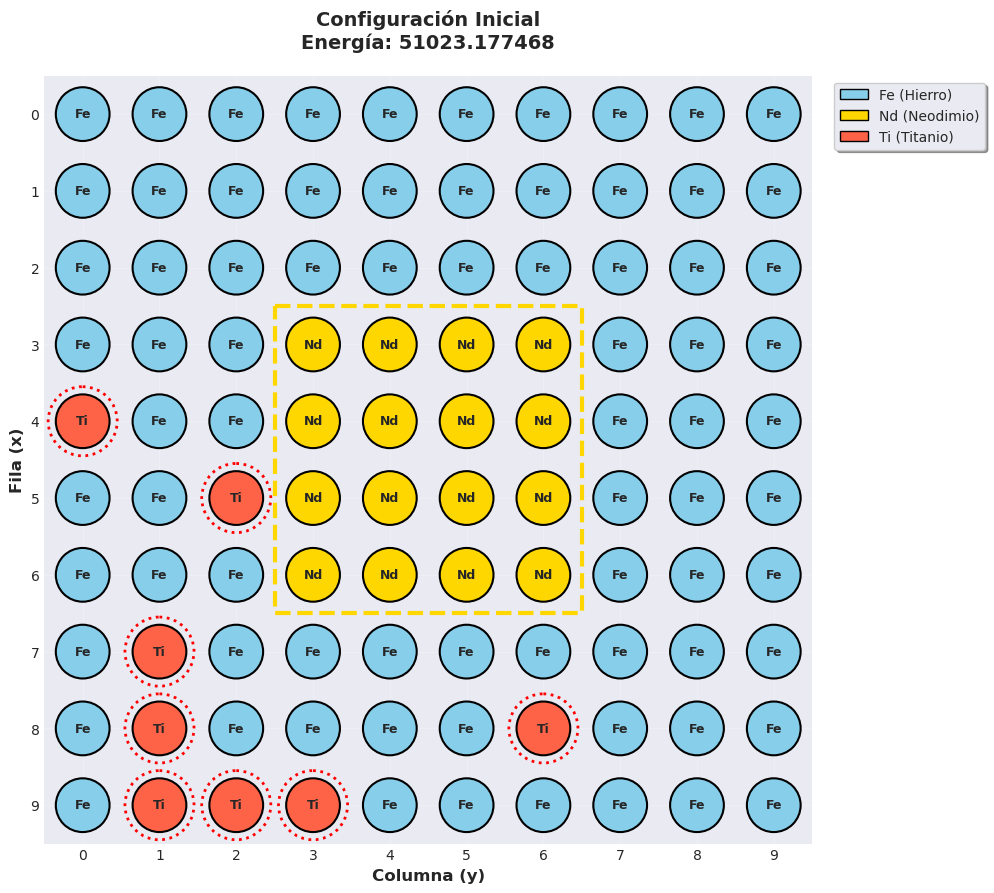

Energía inicial: 51023.177468


In [22]:
energia_inicial = compute_total_energy_fast(grid_inicial, morse_params)
fig = plot_grid_configuration(grid_inicial, Ti_inicial, energia=energia_inicial, title="Configuración Inicial")
plt.show()
print(f"Energía inicial: {energia_inicial:.6f}")

## 3. PUNTO 2: Implementación SA

In [23]:
T0 = 1000
alpha = 0.995
max_iter = 3000
print(f"Parámetros SA: T0={T0}, α={alpha}, iter={max_iter:,}")

Parámetros SA: T0=1000, α=0.995, iter=3,000


## 4. PUNTO 3: Análisis de Resultados

In [24]:
N_RUNS = 100000
print(f"Ejecutando {N_RUNS} runs en paralelo...")
t_inicio = time.time()
resultados = ejecutar_multiples_runs(N_RUNS, T0, alpha, max_iter, morse_params, n_jobs=-1, verbose=10)
t_total = time.time() - t_inicio
print(f"\n✓ Completado en {t_total:.2f}s ({t_total/N_RUNS:.2f}s/run)")

Ejecutando 100000 runs en paralelo...
Ejecutando 100000 runs de Simulated Annealing en paralelo...
  Parámetros: T0=1000, α=0.995, max_iter=3000
  Jobs paralelos: -1 (todos los cores)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.012410640716552734s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04405093193054199s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08142590522766113s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1645514965057373s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 360 tasks     


✓ Completados 100000 runs

Estadísticas:
  Mejor energía: 48679.973344
  Peor energía: 48728.333086
  Media: 48681.717124
  Desv. estándar: 8.952882
  Mejora promedio: 4.40%

✓ Completado en 93.25s (0.00s/run)


In [25]:
mejor_run = get_best_run(resultados)
stats = get_run_statistics(resultados)
print(f"Mejor energía: {mejor_run['energia_final']:.6f}")
print(f"Media: {stats['energia_media']:.6f} ± {stats['energia_std']:.6f}")

Mejor energía: 48679.973344
Media: 48681.717124 ± 8.952882


In [26]:
# Análisis de convergencia del mejor run
print("\n" + "="*70)
print("CONVERGENCIA AL ÓPTIMO - MEJOR RUN")
print("="*70)
print(f"Run ID:                     {mejor_run['run_id']}")
print(f"Iteración de convergencia:  {mejor_run['iterations_to_best']:,}/{max_iter:,}")
print(f"Porcentaje del tiempo:      {(mejor_run['iterations_to_best']/max_iter)*100:.1f}%")
print(f"Temperatura en convergencia: T = {T0 * (alpha ** mejor_run['iterations_to_best']):.6f}")
print("="*70)

# Estadísticas de convergencia de TODOS los runs
iter_convergencias = [r['iterations_to_best'] for r in resultados]
print(f"\nESTADÍSTICAS DE CONVERGENCIA (todos los {N_RUNS} runs):")
print(f"  Media:    {np.mean(iter_convergencias):,.0f} iteraciones")
print(f"  Mediana:  {np.median(iter_convergencias):,.0f} iteraciones")
print(f"  Mínimo:   {np.min(iter_convergencias):,} iteraciones (run más rápido)")
print(f"  Máximo:   {np.max(iter_convergencias):,} iteraciones (run más lento)")
print(f"  Std:      {np.std(iter_convergencias):,.0f} iteraciones")
print("="*70)

# Interpretación
pct_convergencia = (mejor_run['iterations_to_best']/max_iter)*100
if pct_convergencia < 50:
    print(f"\n✓ El algoritmo converge RÁPIDO (en {pct_convergencia:.1f}% del tiempo)")
    print("  → Podrías reducir max_iter para mayor eficiencia")
elif pct_convergencia < 80:
    print(f"\n✓ El algoritmo está bien calibrado (converge en {pct_convergencia:.1f}% del tiempo)")
    print("  → Balance óptimo entre exploración y convergencia")
else:
    print(f"\n⚠ El algoritmo converge TARDE (en {pct_convergencia:.1f}% del tiempo)")
    print("  → Considera aumentar max_iter o ajustar parámetros")


CONVERGENCIA AL ÓPTIMO - MEJOR RUN
Run ID:                     27558
Iteración de convergencia:  1,614/3,000
Porcentaje del tiempo:      53.8%
Temperatura en convergencia: T = 0.306515

ESTADÍSTICAS DE CONVERGENCIA (todos los 100000 runs):
  Media:    1,473 iteraciones
  Mediana:  1,365 iteraciones
  Mínimo:   248 iteraciones (run más rápido)
  Máximo:   2,999 iteraciones (run más lento)
  Std:      492 iteraciones

✓ El algoritmo está bien calibrado (converge en 53.8% del tiempo)
  → Balance óptimo entre exploración y convergencia


### GRÁFICA 1: Configuración Óptima

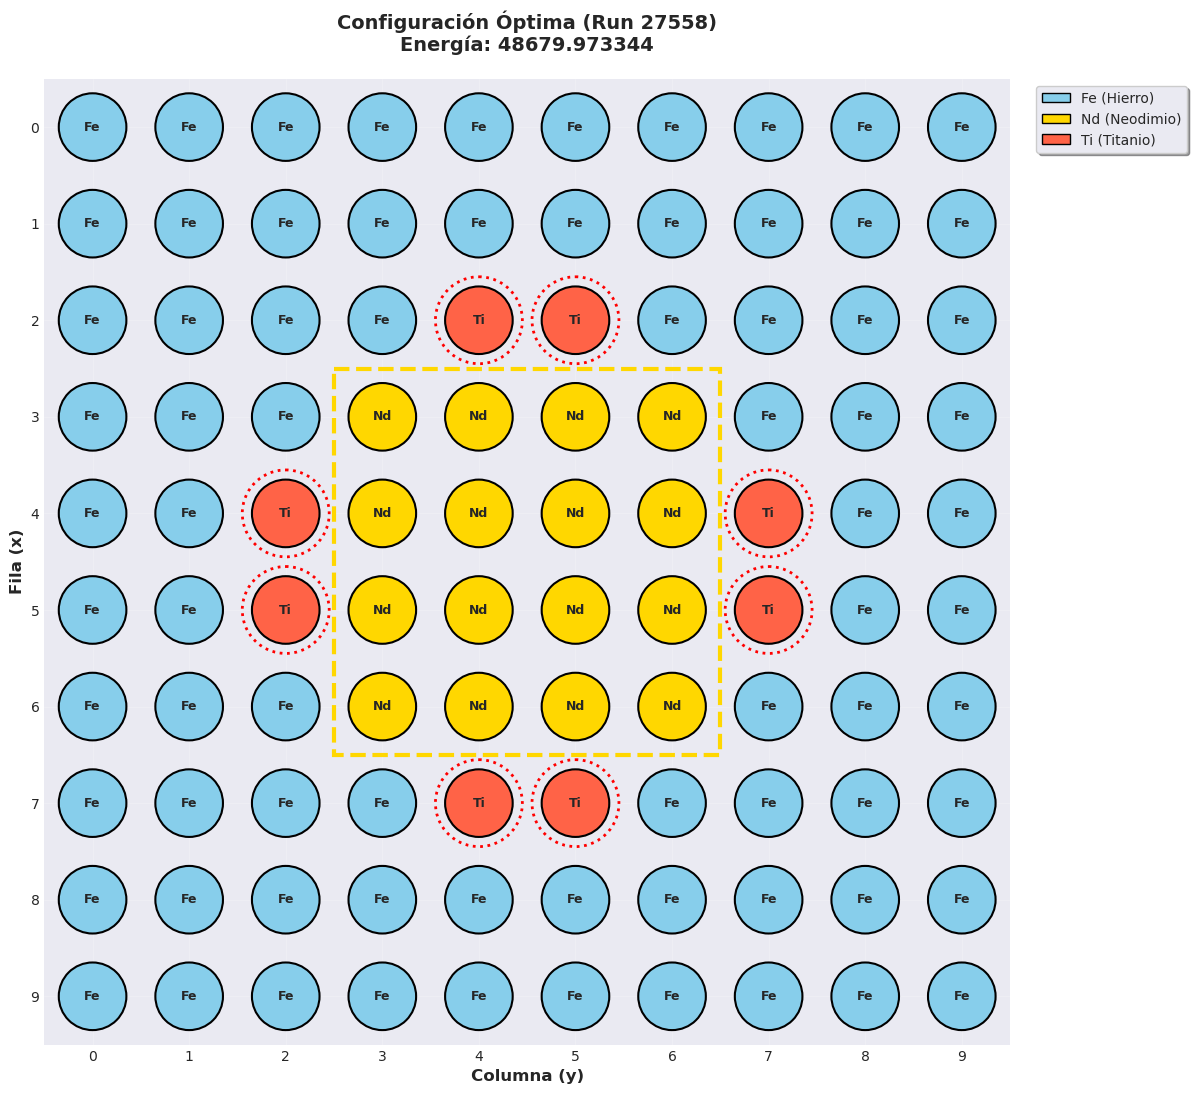

In [27]:
fig = plot_grid_configuration(mejor_run['grid_best'], mejor_run['Ti_best'], 
                              energia=mejor_run['energia_final'], 
                              title=f"Configuración Óptima (Run {mejor_run['run_id']})",
                              figsize=(12, 12))
plt.show()

### GRÁFICA 2: Energía vs Iteración

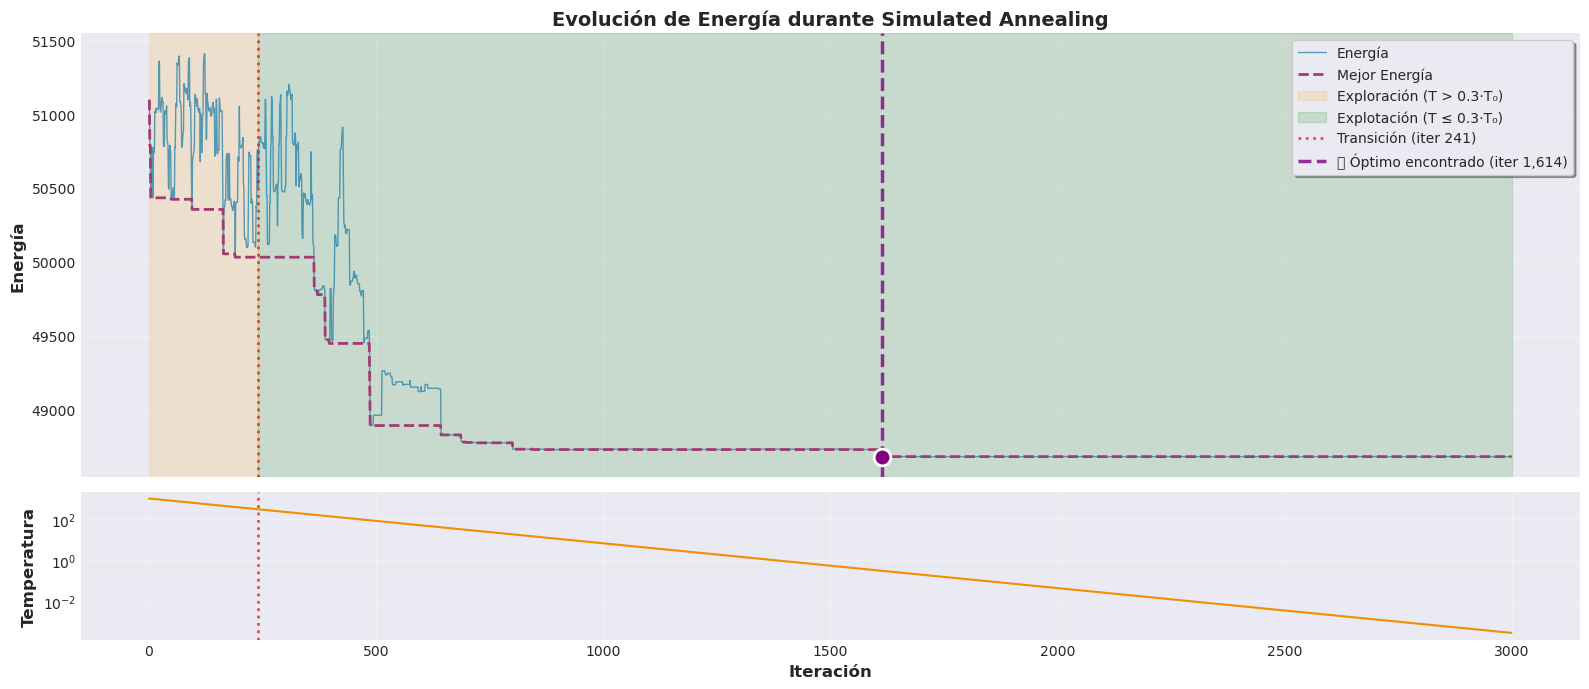


🎯 El óptimo se encontró en la iteración 1,614 de 3,000
   (53.8% del tiempo total)
   Temperatura en convergencia: T = 0.306515


In [28]:
# Preparar history del mejor run
history_mejor = {
    'energy': mejor_run['energy_history'],
    'temperature': T0 * (alpha ** np.arange(len(mejor_run['energy_history']))),
    'accepted': np.zeros(len(mejor_run['energy_history']), dtype=bool)
}

# Crear gráfica de evolución de energía
fig = plot_energy_evolution(history_mejor, highlight_phases=True, 
                            exploration_threshold=0.3, figsize=(16, 7))

# AGREGAR MARCA VISUAL DE CONVERGENCIA
ax = fig.axes[0]  # Primer subplot (energía)
iter_best = mejor_run['iterations_to_best']

# Línea vertical en el punto de convergencia
ax.axvline(iter_best, color='purple', linestyle='--', linewidth=2.5, 
           label=f'🎯 Óptimo encontrado (iter {iter_best:,})', alpha=0.8, zorder=10)

# Punto marcador en la convergencia
energia_convergencia = mejor_run['energy_history'][iter_best]
ax.plot(iter_best, energia_convergencia, 'o', color='purple', 
        markersize=12, markeredgecolor='white', markeredgewidth=2, zorder=11)

# Actualizar leyenda
ax.legend(loc='upper right', fontsize=10, frameon=True, shadow=True)

plt.tight_layout()
plt.show()

# Información de convergencia
print(f"\n🎯 El óptimo se encontró en la iteración {iter_best:,} de {max_iter:,}")
print(f"   ({(iter_best/max_iter)*100:.1f}% del tiempo total)")
print(f"   Temperatura en convergencia: T = {T0 * (alpha ** iter_best):.6f}")

### Análisis Espacial

In [29]:
patron = analizar_patron_espacial(mejor_run['Ti_best'], Nd_fijas, grid_size=10)
print("\nANÁLISIS ESPACIAL")
print(f"Dist. Ti-Nd promedio: {patron['dist_Ti_Nd_promedio']:.3f} Å")
print(f"Dist. Ti-Ti promedio: {patron['dist_Ti_Ti_promedio']:.3f} Å")
print(f"Clustering score: {patron['clustering_score']:.3f}")
print(f"Dist. al centro: {patron['dist_centro_promedio']:.3f}")


ANÁLISIS ESPACIAL
Dist. Ti-Nd promedio: 1.000 Å
Dist. Ti-Ti promedio: 3.626 Å
Clustering score: 0.715
Dist. al centro: 2.550


In [30]:
interpretacion = interpretar_patron(patron)
print("\nINTERPRETACIÓN:")
print(interpretacion)


INTERPRETACIÓN:
Los átomos de Ti se ubican relativamente CERCA de los átomos de Nd (distancia promedio: 1.00 Å).
Los Ti se distribuyen cerca del CENTRO de la grilla (distancia al centro: 2.55).
Los Ti tienden a AGRUPARSE (clustering score: 0.715, dist. promedio Ti-Ti: 3.63 Å).

✗ Este patrón NO confirma completamente la hipótesis del Punto 1.


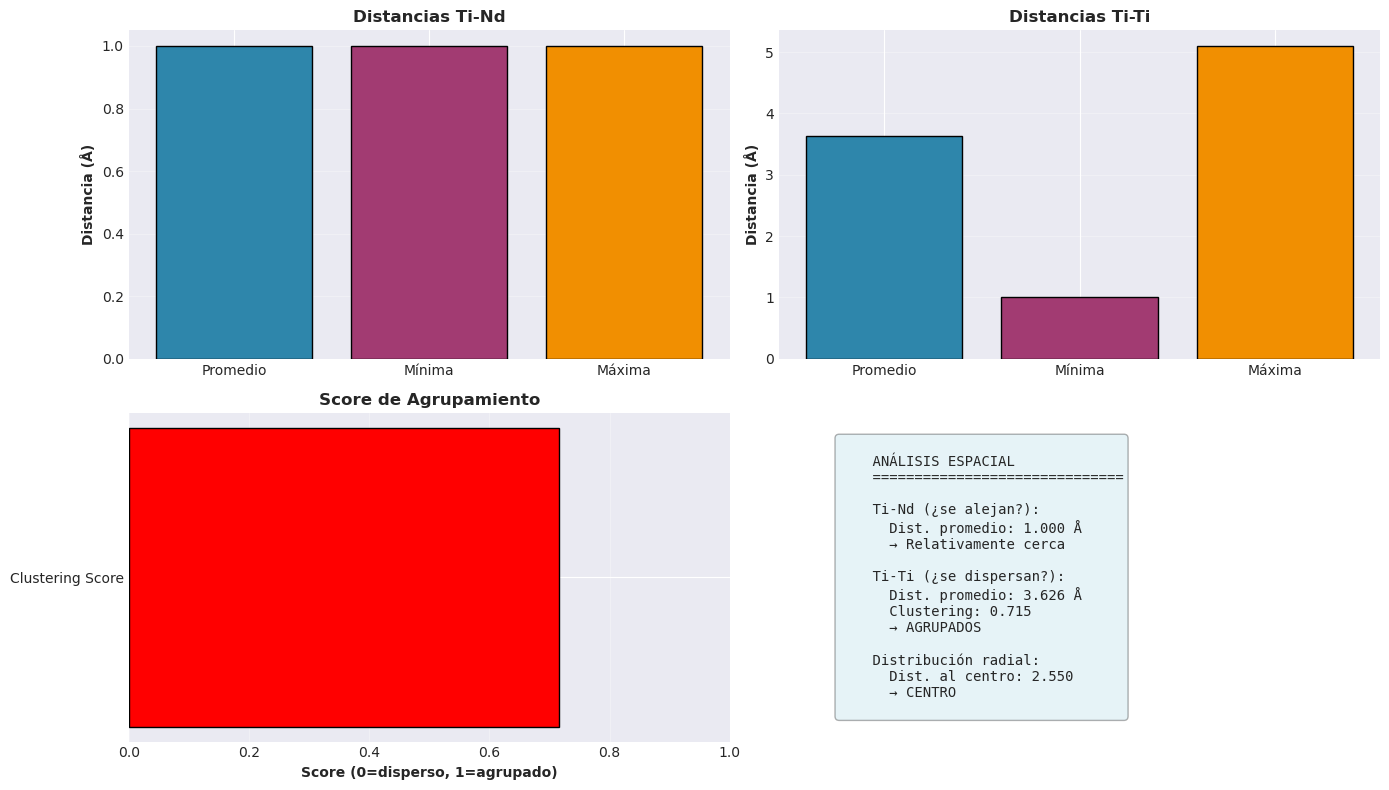

In [31]:
fig = plot_spatial_metrics(patron, figsize=(14, 8))
plt.show()

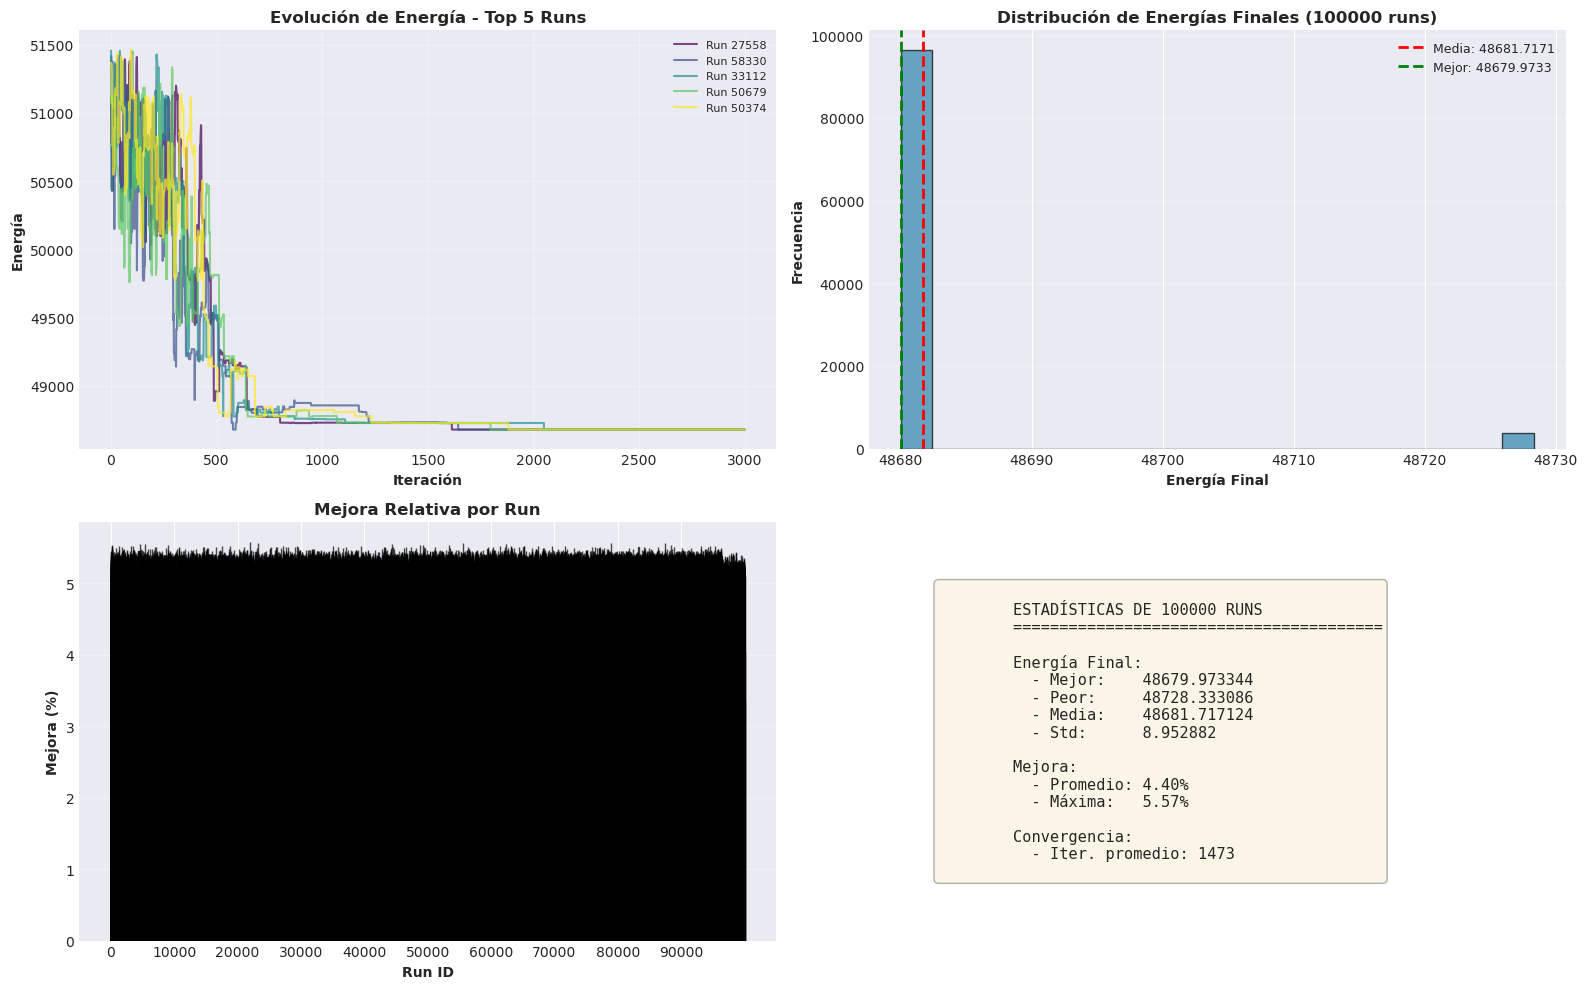

In [32]:
fig = plot_multiple_runs_comparison(resultados, top_n=min(5, N_RUNS), figsize=(16, 10))
plt.show()